# PCA and Clustering Notebook

The objective of using both PCA and clustering is to perform feature engineering to perform a semi-supervised approach, as PCA and clustering form the unsupervised portion of the work. 

Principal Component Analysis (PCA) is a dimensionality reduction technique that is used to reduce the number of features of large datasets. It does it by transforming a large set of features into a smaller one, mostly 2 principal components (PC), that still contain most of the information in the large dataset, which is quantified by the variance of the dataset. PCA is computed such that the first PC will represent the highest explained variance, followed by PC2, PC3, etc… Each PC is a linear combination of all features used to construct the PCs. With this in mind, we leverage PCA to obtain the best two PCs i.e., PC1 and PC2, then perform clustering on them. Coupling PCA with clustering is better than performing pair-wise clustering on the original or generated features as essentially all PCs contain the information from all features. Finally based on the scatter plot of PC1 vs. PC2, we have experimented with various clustering techniques, namely K-means, K-medoids, DBSCAN, and Hierarchical Clustering, and it is concluded that DBSCAN is the most effective at clustering the PCs. 

The result of this is 3 new features – PC1, PC2 and DBSCAN cluster which would be used together with the models.

In [72]:
%reload_ext autoreload
%autoreload 2

from preprocessing_merge import *
from preprocessing_train_test import *
from clustering import *
import scipy as sp
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [41]:
# # Read train and test data
# DATAPREPROCESSING_DIRECTORY = "../data/backup/"
# train_df = pd.read_csv(DATAPREPROCESSING_DIRECTORY+"merge_hdbtrainstpop_train.csv") # This is a previous dataset, we generated, can replace with "../data/backup/merge_auxiliary_data_train.csv"
# test_df = pd.read_csv(DATAPREPROCESSING_DIRECTORY+"merge_hdbtrainstpop_test.csv") # This is a previous dataset, we generated, can replace with "../data/backup/merge_auxiliary_data_test.csv"

# EDA for clusters

In [70]:
# # Check variance of the data (First 30 columns)
# # Clustering is probably helpful for data with larger variances --> std**2
# train_df.iloc[:, :30].describe()

,floor_area_sqm,lease_commence_date,elevation,resale_price,opening_year,distance_to_mrt,distance_to_mrt_km,mrt_lrt_links,mrt_interchange_flag,mrt_interchange_count,distance_to_mrt_bins,population_count,adult_count,children_count
count,431101.000000,431101.000000,431101.0,4.311010e+05,378882.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000
mean,96.983167,1989.420758,0.0,3.018275e+05,1996.649764,0.005882,0.652556,0.013340,0.099861,0.099861,0.088685,42449.893296,22465.604232,4146.232577
std,25.191689,10.251010,0.0,1.298678e+05,10.779785,0.003456,0.383359,0.114727,0.299814,0.299814,0.285144,30254.682071,15955.374974,3025.570655
min,31.000000,1966.000000,0.0,2.970000e+04,1987.000000,0.000200,0.022112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,1983.000000,0.0,2.052000e+05,1988.000000,0.003312,0.367597,0.000000,0.000000,0.000000,0.000000,23940.000000,12660.000000,2020.000000
50%,99.000000,1988.000000,0.0,2.839500e+05,1990.000000,0.005297,0.587645,0.000000,0.000000,0.000000,0.000000,33410.000000,17440.000000,3150.000000
75%,114.000000,1997.000000,0.0,3.735000e+05,2003.000000,0.007747,0.860116,0.000000,0.000000,0.000000,0.000000,54880.000000,29740.000000,6140.000000
max,280.000000,2019.000000,0.0,1.123200e+06,2031.000000,0.031795,3.515776,1.000000,1.000000,1.000000,2.000000,138490.000000,72740.000000,12040.000000


In [71]:
# # Check variance of the data (31st columns and beyond)
# train_df.iloc[:, 31:].describe()

,teenager_count,young_adult_count,female_count,male_count,male_female_ratio,male_female_ratio_bins,adult_children_ratio,adult_children_ratio_bins,population_bins
count,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000,431101.000000
mean,5232.399600,6162.834788,21483.474081,20966.419215,0.971089,1.999197,3.545471,0.159287,0.382354
std,4062.089314,4875.184865,15300.622271,14962.227449,0.044491,0.038941,0.701280,0.365944,0.634668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2470.000000,3170.000000,12470.000000,11920.000000,0.955176,2.000000,2.885173,0.000000,0.000000
50%,3950.000000,4610.000000,16840.000000,16320.000000,0.977480,2.000000,3.589521,0.000000,0.000000
75%,6480.000000,8140.000000,27770.000000,27200.000000,0.996490,2.000000,4.017435,0.000000,1.000000
max,16780.000000,22580.000000,70600.000000,67890.000000,1.236239,2.000000,8.533333,1.000000,2.000000


In [ ]:
# # Pairwise scatter plot to see if there is any distinctive clusters that can be formed
# # If don't have, can do PCA/TSNE transformation before clustering
# fig = sns.pairplot(train_df)
# plt.show()

# Take important columns

In [ ]:
# Prepare train-test dataframe for PCA and clustering

train_dataset = pd.read_csv("../data/backup/merge_auxiliary_data_train.csv")
test_dataset = pd.read_csv("../data/backup/merge_auxiliary_data_test.csv")
train_df, test_df = preprocess_train_test(train_dataset, test_dataset)

In [ ]:
# Using the following columns to perform PCA and clustering 
# We tried quite a few different feature sets, the following sets gives the best cumulative variance amongst the first 2 PCs. 
# selected_columns = list(train_df.columns)
selected_columns = ['floor_area_sqm', 'distance_to_mrt', 'population_count', 'adult_count', 'children_count', \
                    'senior_citizen_count', 'teenager_count', 'female_count', 'male_count']# Using the following columns to perform PCA and clustering 

# PCA/tsne clustering

In [46]:
X = train_df.loc[:, selected_columns].values
X = StandardScaler().fit_transform(X)

In [47]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [48]:
finalDf = pd.concat([principalDf, train_df[['resale_price']]], axis = 1)

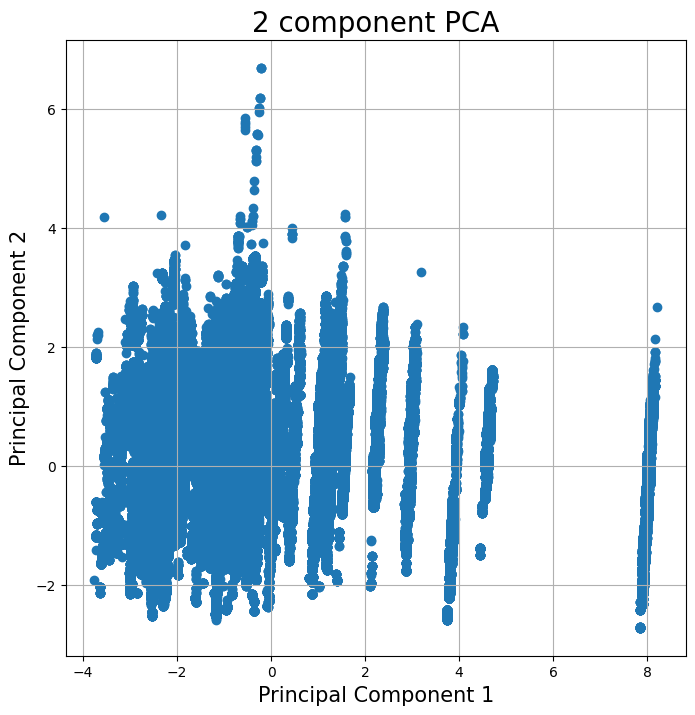

In [49]:
# Plot principal components only
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'])
ax.grid()

# K-means clustering

Cluster labels:
 [1 1 1 ... 1 1 1]


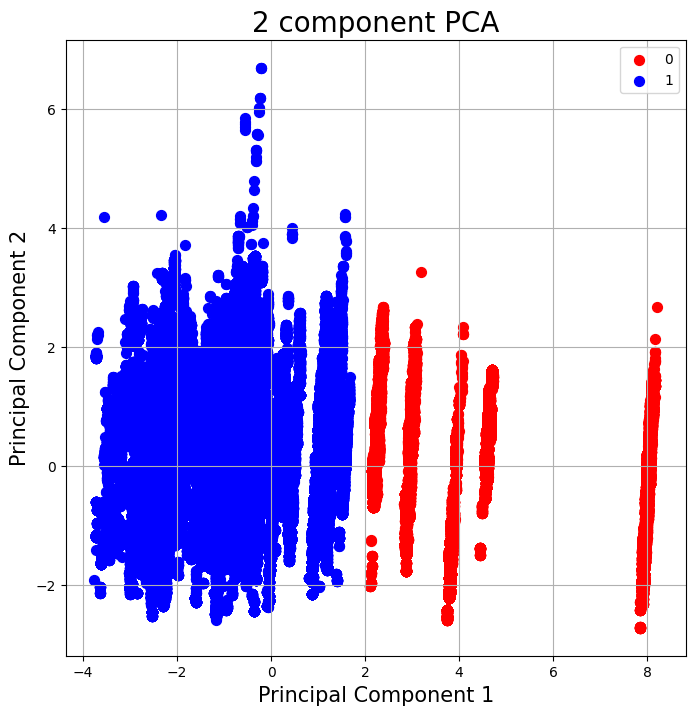

In [50]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(finalDf[['principal component 1', 'principal component 2']])
labels = kmeans.labels_
print('Cluster labels:\n', labels)
finalDf["Kmeans_cluster"] = labels

# Plot principal components only + colored by K-means clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Kmeans_cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Sample data

Large data - difficult to run on K-medoids, DBScan and Hierarchical Clustering

In [51]:
new_df = finalDf.groupby('Kmeans_cluster').sample(n=1000)

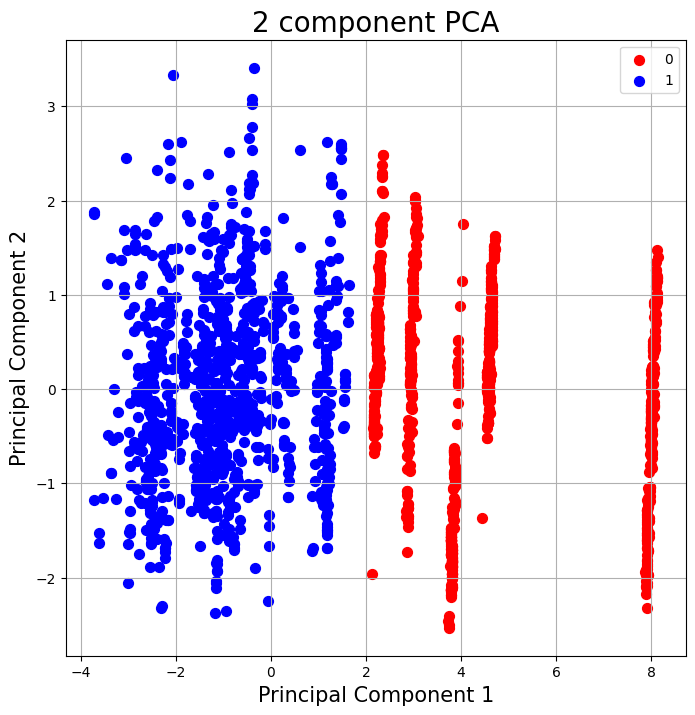

In [52]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = new_df['Kmeans_cluster'] == target
    ax.scatter(new_df.loc[indicesToKeep, 'principal component 1']
               , new_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# K-medoids cluster

Cluster labels:
 [2 1 2 ... 0 1 0]


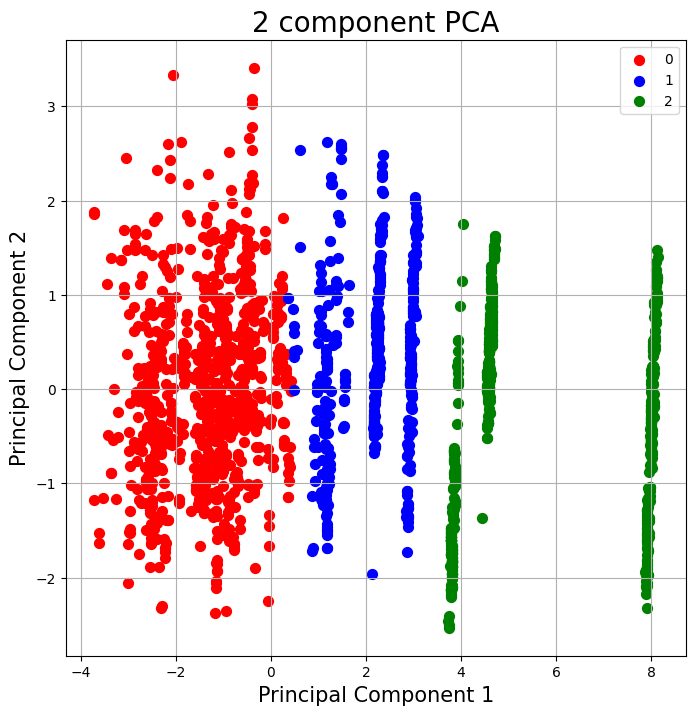

In [54]:
k=3
kmedoids = KMedoids(n_clusters=k)
kmedoids.fit(new_df[['principal component 1', 'principal component 2']])
labels = kmedoids.labels_
print('Cluster labels:\n', labels)
new_df["Kmedoids_cluster"] = labels

# Plot principal components only
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = new_df['Kmedoids_cluster'] == target
    ax.scatter(new_df.loc[indicesToKeep, 'principal component 1']
               , new_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# DBscan Clustering

Cluster labels:
 [0 0 1 ... 0 0 0]
Cluster labels unique count:
 {0, 1}


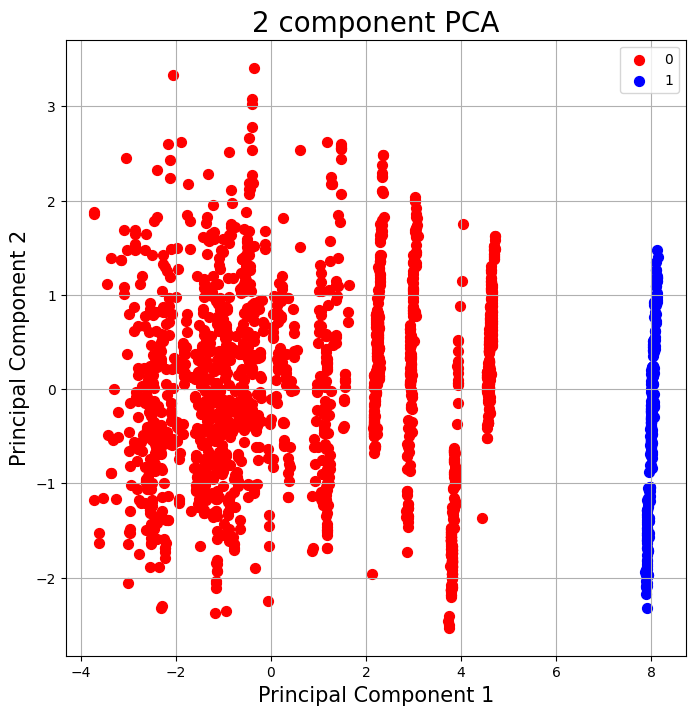

In [55]:
eps=2
min_samples=10
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(new_df[['principal component 1', 'principal component 2']])
labels = dbscan.labels_
print('Cluster labels:\n', labels)
print('Cluster labels unique count:\n', set(list(labels)))
new_df["DBSCAN_cluster"] = labels

# Plot principal components only
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = new_df['DBSCAN_cluster'] == target
    ax.scatter(new_df.loc[indicesToKeep, 'principal component 1']
               , new_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Hierarchical Clustering

Cluster labels:
 [0 0 2 ... 1 1 1]
Cluster labels unique count:
 {0, 1, 2}


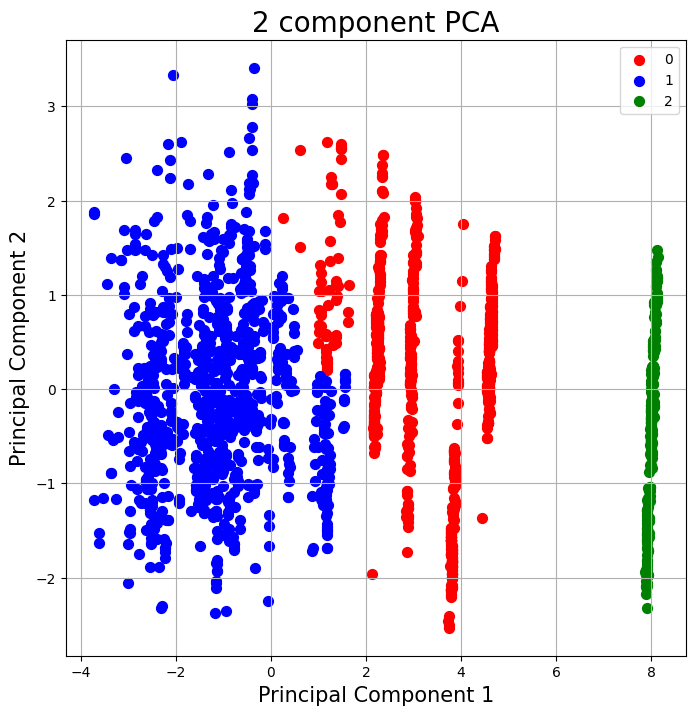

In [56]:
k=3
hcluster = AgglomerativeClustering(n_clusters=k)
hcluster.fit(new_df[['principal component 1', 'principal component 2']])
labels = hcluster.labels_
print('Cluster labels:\n', labels)
print('Cluster labels unique count:\n', set(list(labels)))
new_df["Hierarchical_cluster"] = labels

# Plot principal components only
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = new_df['Hierarchical_cluster'] == target
    ax.scatter(new_df.loc[indicesToKeep, 'principal component 1']
               , new_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Inference cluster on full dataset

In [58]:
def dbscan_predict(model, X):
    '''Predict DBSCAN clusters on full  dataset based on euclidean distance'''

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [60]:
new_labels = dbscan_predict(dbscan, np.asarray(finalDf[['principal component 1', 'principal component 2']]))
updated_finalDf = pd.concat([finalDf, pd.DataFrame(new_labels, columns=["DBSCAN_cluster"])], axis=1)
final_train_df = pd.concat([train_df, updated_finalDf[['principal component 1', 'principal component 2', "Kmeans_cluster", "DBSCAN_cluster"]]], axis=1)

# Evaluate cluster

Best clustering technique is using DBSCAN. See how it outperforms the original variables?

In [64]:
final_train_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,male_count,male_female_ratio,male_female_ratio_bins,adult_children_ratio,adult_children_ratio_bins,population_bins,principal component 1,principal component 2,Kmeans_cluster,DBSCAN_cluster
0,2001-08,pasir ris,4-room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,29530.0,0.984990,2,3.094151,0,1,1.396519,1.225899,1,0
1,2002-09,pasir ris,4-room,473,pasir ris drive 6,04 to 06,103.0,model a,uncategorized,1989,...,29530.0,0.984990,2,3.094151,0,1,1.361895,0.485245,1,0
2,2020-10,pasir ris,executive,220,pasir ris street 21,10 to 12,152.0,apartment,uncategorized,1993,...,29530.0,0.984990,2,3.094151,0,1,1.481569,2.625785,1,0
3,2010-10,pasir ris,4-room,474,pasir ris drive 6,04 to 06,105.0,model a,uncategorized,1989,...,29530.0,0.984990,2,3.094151,0,1,1.368843,0.485002,1,0
4,2002-08,pasir ris,4-room,751,pasir ris street 71,04 to 06,104.0,model a,uncategorized,1996,...,17970.0,0.977693,2,2.671162,0,0,-0.510477,1.476498,1,0


In [67]:
# Identify cateogrical columns based on how much unique values there is in the column
categorical_column_list = []
for col in final_train_df.columns: 
    print(col)
    if final_train_df[col].nunique() < 30:
        if col != "train":
            categorical_column_list.append(col)
        # print(merge_train_data[col].unique())
        
print(categorical_column_list)
print(len(categorical_column_list))

final_train_df[categorical_column_list] = final_train_df[categorical_column_list].astype('category')

month
town
flat_type
block
street_name
storey_range
floor_area_sqm
flat_model
eco_category
lease_commence_date
elevation
subzone
planning_area
region
resale_price
geometry
mrt_name
codes
opening_year
type
distance_to_mrt
distance_to_mrt_km
mrt_lrt_links
mrt_interchange_flag
mrt_interchange_count
codes_name
distance_to_mrt_bins
population_count
adult_count
children_count
senior_citizen_count
teenager_count
young_adult_count
female_count
male_count
male_female_ratio
male_female_ratio_bins
adult_children_ratio
adult_children_ratio_bins
population_bins
principal component 1
principal component 2
Kmeans_cluster
DBSCAN_cluster
['town', 'flat_type', 'storey_range', 'flat_model', 'eco_category', 'elevation', 'region', 'opening_year', 'type', 'mrt_lrt_links', 'mrt_interchange_flag', 'mrt_interchange_count', 'codes_name', 'distance_to_mrt_bins', 'male_female_ratio_bins', 'adult_children_ratio_bins', 'population_bins', 'Kmeans_cluster', 'DBSCAN_cluster']
19


In [69]:
# Generating correlation using Chi2 Test of Independence
# Null Hypothesis: There is no association between variables
# Alternative: There is association between variables
# When p-value is < 0.05, the categorical input columns have a correlation to the response (resale_price) and can be considered for model training 

chi2_train = chisquared_calc(final_train_df, categorical_column_list)
print("Categorical column that have statstical significance:")
display(chi2_train.loc[chi2_train.Pvalue<=0.05, :].sort_values("Pvalue", ascending=True))

print("Categorical column that does not have statstical significance:")
display(chi2_train.loc[chi2_train.Pvalue>0.05, :])

Categorical column that have statstical significance:


,Categorical_Column,Chi2_Statistic,Pvalue
0,town,299128.378243,0.000000e+00
1,flat_type,471989.917161,0.000000e+00
2,storey_range,956545.170749,0.000000e+00
3,flat_model,671730.762684,0.000000e+00
6,region,67460.625131,0.000000e+00
7,opening_year,150753.990608,0.000000e+00
8,type,19034.596291,0.000000e+00
12,codes_name,130784.509552,0.000000e+00
15,adult_children_ratio_bins,20558.355618,0.000000e+00
16,population_bins,22032.621314,0.000000e+00


Categorical column that does not have statstical significance:


,Categorical_Column,Chi2_Statistic,Pvalue
4,eco_category,0.000000,1.0
5,elevation,0.000000,1.0
14,male_female_ratio_bins,4151.955479,1.0
